In [1]:
import torch
import math
import numpy as np
import os
from natsort import natsorted
import matplotlib.pyplot as plt
from torch import optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.nn.utils import clip_grad_value_
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from scipy.ndimage import zoom
from glob import glob
import nibabel as nib
from tqdm import tqdm
import cv2
import torch.nn.functional as F


# Outline for dataloader
- reads in the original nifti 3d image
- reads in the gradCAM
- based on the gradCAM, choose the most significant slice of the nifti image
    - choose 3 different slices from the 3 directions   
- output the 3 slices in 3 channels

In [2]:
def naive_sample(images):
    means = [np.mean(img) for img in images]
    non_zero_indices = np.nonzero(means)
    #mode = np.argmax(means)
    mini = np.min(non_zero_indices)
    maxi = np.max(non_zero_indices) 
    adj = (maxi-mini) / 4
    mini_adj = np.min(non_zero_indices) + adj
    maxi_adj = np.max(non_zero_indices) - adj
    return np.linspace(mini_adj, maxi_adj, 15, dtype=int)

In [7]:
def downsize_transform(data): 
    target_size = (192, 192, 192)
    data = torch.from_numpy(data).unsqueeze(0).unsqueeze(0)
    downsampled = torch.nn.functional.interpolate(data, size=target_size, mode='trilinear')

    return downsampled.squeeze(0).squeeze(0)

class TransformerDataset(Dataset):
    def __init__(self, img_dir, grad_dir, transforms = None):
        self.img_dir = img_dir
        self.grad_dir = grad_dir
        self.transforms = transforms
        self.cn_dir = os.path.join(self.img_dir, "MNI152_affine_WB_iso1mm/CN")
        self.scz_dir = os.path.join(self.img_dir, "MNI152_affine_WB_iso1mm/schiz")
        self.grad_cn_dir = os.path.join(self.grad_dir, "MNI152_affine_WB_iso1mm/CN")
        self.grad_scz_dir = os.path.join(self.grad_dir, "MNI152_affine_WB_iso1mm/CN") # change this later when rerun the extract grad script
        self.samples, self.labels = self._load_samples()

    def _load_samples(self):
        samples = []
        
        samples = [file for file in os.listdir(self.cn_dir) if file.endswith(".nii.gz")]
        labels = [0] * len(samples)
        samples += [file for file in os.listdir(self.scz_dir) if file.endswith(".nii.gz")]
        labels += [1] * (len(samples) - len(labels))

        return samples, labels

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        k = 3
        label = self.labels[idx]
        grad_file = self.samples[idx].split(".")[0]
        if label == 0:
            file_path = os.path.join(self.cn_dir, self.samples[idx])
            grad_path = os.path.join(self.grad_cn_dir, grad_file+ ".nii_activation.nii.gz")
        else:
            file_path = os.path.join(self.scz_dir, self.samples[idx])
            grad_path = os.path.join(self.grad_scz_dir, grad_file+ ".nii_activation.nii.gz")
        one_hot_label = torch.zeros(2)
        one_hot_label[label] = 1
        label = one_hot_label

        img = nib.load(file_path)
        grad = nib.load(grad_path)

        img_data = np.float32(img.get_fdata())
        # for img in img_data:
        #     print(img.shape)
        #     break
        test_img = naive_sample(img_data)
        # print(test_img.shape)
        img_data = self.transforms(img_data)

        grad_data = np.float32(grad.get_fdata())
        sums_x = np.sum(grad_data, axis=(1, 2))
        sums_y = np.sum(grad_data, axis=(0, 2))
        sums_z = np.sum(grad_data, axis=(0, 1))

        x_slices = np.argsort(sums_x)[::-1][:k]
        x_copy = x_slices.copy()
        y_slices = np.argsort(sums_y)[::-1][:k]
        y_copy = y_slices.copy()
        z_slices = np.argsort(sums_z)[::-1][:k]
        z_copy = z_slices.copy()
        x_copy = np.array(np.arange(70, 81, 5))
        y_copy = np.array(np.arange(70, 81, 5))
        z_copy = np.array(np.arange(70, 81, 5))

        x_slice = img_data[test_img, :, :]
        y_slice = img_data.permute(1, 0, 2)
        z_slice = img_data[:, :, z_copy].permute(2, 0, 1)
        return x_slice, label
        # return np.concatenate((x_slice, y_slice, z_slice), axis = 0), label

In [23]:
root_dir = "/media/youzhi/SSD/bme_project/data"
grad_root_dir = "/media/youzhi/SSD/bme_project/activations"
folds_dir = [dir for dir in os.listdir(root_dir) if dir.startswith("fold")]
grads_dir = [os.path.join(grad_root_dir, dir) for dir in folds_dir]
folds_dir = [os.path.join(root_dir, dir) for dir in folds_dir]
folds_dir = natsorted(folds_dir)
grads_dir = natsorted(grads_dir)
dataloaders = []
for i in range(len(folds_dir)):
    fold_dir = folds_dir[i]
    grad_dir = grads_dir[i]
    dataset = TransformerDataset(fold_dir, grad_dir, downsize_transform) #, downsize_transform)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
    dataloaders.append(dataloader)
    print("fold", i+1, ": ", len(dataset))

fold 1 :  196
fold 2 :  188
fold 3 :  187
fold 4 :  185
fold 5 :  187
fold 6 :  185
fold 7 :  187
fold 8 :  182
fold 9 :  188
fold 10 :  187


In [29]:
sample = next(iter(dataloaders[0]))
reshaped = sample[0].view(-1, 192, 192)
label = sample[1]
# print(sample[0].shape)
# print(reshaped.unsqueeze(1).shape)
repeat_label = torch.repeat_interleave(label, sample[0].shape[1], dim=0)
# print(repeat_label.shape)
# print(label.shape)
# print(label)
# print(repeat_label)

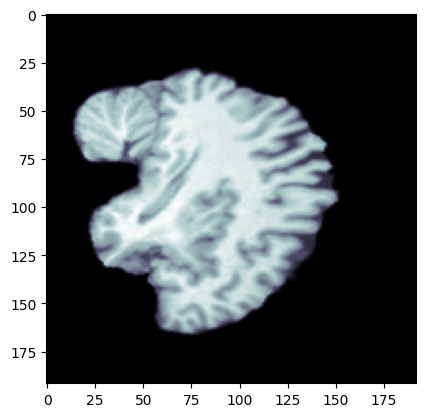

In [31]:
plt.imshow(sample[0][0][0], cmap = 'bone')